In [1]:
FENG_LFP_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'
FENG_ITN_PATH = '/home/matt/data/InVivoLFPs/FengData/FR_PN_ITN.txt'

In [2]:
from lfp_prediction.data_gathering import TextCollector

frequency_band = (55, 85)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
dc = TextCollector(FENG_LFP_PATH)
lfp = dc.get_data(column=None)
dc = TextCollector(FENG_ITN_PATH)
itn = dc.get_data(column=2)

del dc

print(lfp.shape)
print(itn.shape)

(3000001, 1)
(3000001, 1)


In [3]:
from scipy import signal
import numpy as np

corr = signal.correlate(lfp, itn, mode='same')
corr /= np.max(corr)

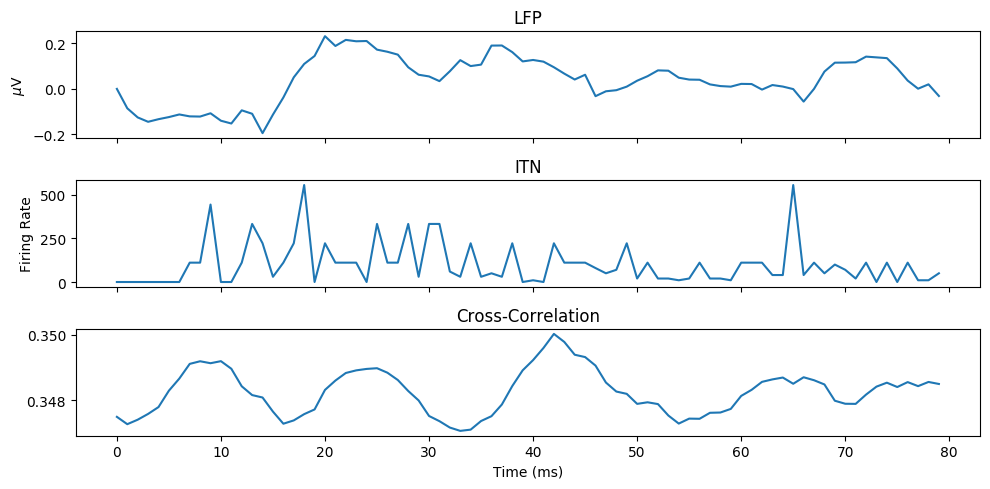

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex='all', figsize=(10, 5))
ax1.plot(lfp[:80])
ax1.set_title('LFP')
ax1.set_ylabel(r'$\mu$V')
ax2.plot(itn[:80])
ax2.set_title('ITN')
ax2.set_ylabel('Firing Rate')
ax3.plot(corr[:80])
ax3.set_title('Cross-Correlation')
ax3.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

In [5]:
fs = 1000
z, a = signal.butter(4, [60, 70], btype='bandpass', output='ba', fs=fs)
filtered_data = signal.filtfilt(z, a, lfp, axis=0)

LFP_amp = abs(signal.hilbert(filtered_data))
threshold = np.mean(LFP_amp) + (1 * np.std(LFP_amp))

indices = np.argwhere(abs(filtered_data) > threshold)
lfp_mask = np.zeros(filtered_data.shape)
lfp_mask[indices] = 1
print(indices[:,0])
print((indices.shape[0]/filtered_data.shape[0])*100)
print(indices.shape)

[     22      23      24 ... 2999892 2999893 2999900]
16.325061224979592
(489752, 2)


In [6]:
change_idxs = np.diff(lfp_mask, axis=0)
print(change_idxs.shape)
ones = np.argwhere(change_idxs == 1)[:,0]
n_ones = np.argwhere(change_idxs == -1)[:,0]
lfp_mask = np.zeros(filtered_data.shape)
lfp_mask[ones] = 1
lfp_mask[n_ones] = -1

(3000000, 1)


In [44]:
gaps = np.diff(ones, axis=0)
n_gaps = np.diff(n_ones, axis=0)

lfp_gap = np.diff(lfp_mask, axis=0)

ones_idxs = np.argwhere(gaps > 28)[:,0]
n_ones_idxs = np.argwhere(n_gaps > 28)[:,0]
lfp_mask_2 = np.zeros(filtered_data.shape)

full_index_list = np.arange(filtered_data.shape[0])

combo_idxs = np.sort(np.concatenate((ones[ones_idxs], n_ones[n_ones_idxs])), axis=0)
combo_idxs = np.insert(combo_idxs, 0, [0])
combo_idxs = np.append(combo_idxs, filtered_data.shape[0]-1)
print(combo_idxs)

# list_of_bursts = np.split(filtered_data[:,0], combo_idxs.astype(int).tolist())

list_of_bursts = []
i = 0
while i < combo_idxs.shape[0]-1:
    list_of_bursts.append(filtered_data[combo_idxs[i]:combo_idxs[i+1],0])
    i += 2


lob = []
for i, l in enumerate(list_of_bursts):
    m = np.max(l)
    if m < threshold:
        continue
    else:
        # print(i, m, threshold)
        qm = .25 * m
        si = np.argmax(l>qm)
        ei = len(l) - np.argmax(l[::-1]>qm)
        if ei - si < 20:
            continue
        lob.append(l[si:ei])

[      0     145     147 ... 2999589 2999590 3000000]
6290
0.022607722568058417


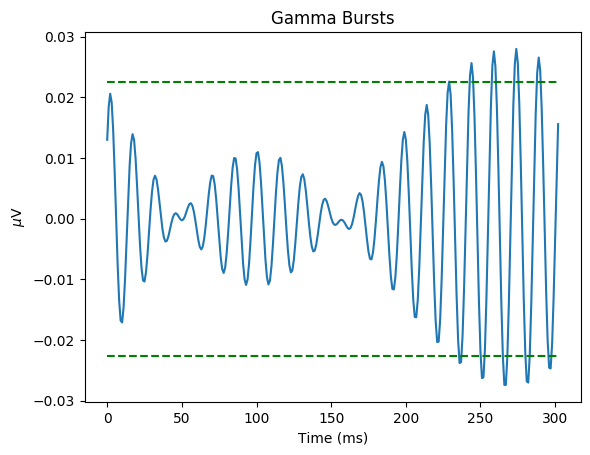

In [45]:
burst_idx = 2
start_idx = combo_idxs[burst_idx-1] if burst_idx > 0 else 0

# t = np.arange(start_idx, combo_idxs[burst_idx])
t = np.arange(lob[burst_idx].shape[0])
burst = lob[burst_idx]
plt.plot(t, burst)
plt.plot(t, [threshold for _ in range(t.shape[0])], 'g--')
plt.plot(t, [-threshold for _ in range(t.shape[0])], 'g--')
plt.title('Gamma Bursts')
plt.ylabel(r'$\mu$V')
plt.xlabel('Time (ms)')
plt.show()

In [ ]:
max_length = max([len(i) for i in gamma_bursts])
min_length = min([len(i) for i in gamma_bursts])
mean_length = np.mean([len(i) for i in gamma_bursts])
print(max_length, min_length, mean_length)